In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Conv2D,Flatten, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow_hub as hub

2023-11-16 15:52:38.558188: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 15:52:38.686486: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 15:52:38.687494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 15:52:39.523560: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#inputs
#dimensions of the images
h=299
d=299
dog=[1,0]
cat=[0,1]

In [3]:
dog_images=[]

dir = '/home/sourav/Downloads/img/train/dogs'

for files in os.listdir(dir):
    dog_images.append(files)

def func_image_reading_reshape(image_list, animal):
    empty_list1=[]
    empty_list2=[]
    for image in image_list:
        image=os.path.join(dir,image)
        image=cv2.imread(image)
        image=cv2.resize(image,(h,d))
        empty_list1.append(image)
        out=animal
        empty_list2.append(out)
    return empty_list1, empty_list2


inp1_tensor, out1_tensor= func_image_reading_reshape(dog_images,dog)

cats_images=[]

dir = '/home/sourav/Downloads/img/train/cats'

for files in os.listdir(dir):
    cats_images.append(files)   

inp2_tensor, out2_tensor= func_image_reading_reshape(cats_images,cat)

inp_tensor=inp1_tensor + inp2_tensor
out_tensor=out1_tensor + out2_tensor

In [4]:
inp_tensor=np.array(inp_tensor)
out_tensor=np.array(out_tensor)

print(inp_tensor.shape)
print(out_tensor.shape)

(557, 299, 299, 3)
(557, 2)


### Normalization of inp_tensor

In [5]:
mean=[]
min=[]
max=[]
for i in range(3):
    mean.append(np.mean(inp_tensor[:,:,:,i]))
    min.append(np.min(inp_tensor[:,:,:,i]))
    max.append(np.max(inp_tensor[:,:,:,i]))

norm_inp=np.zeros((len(inp_tensor),h,d,3))

for i in range(len(inp_tensor)):
    for j in range(h):
        for m in range(d):
            for n in range(3):
               norm_inp[i,j,m,n] =(inp_tensor[i,j,m,n]-mean[n])/max[n] -min[n]

norm_inp.shape

(557, 299, 299, 3)

### Random shuffle of list index

In [6]:
import random

my_list=[]
random.seed(0)

for m in range(len(inp_tensor)):
    my_list.append(m)

shuffled_list = random.sample(my_list, len(my_list))

In [7]:
inp_shuffel=[]
oup_shuffel=[]
for idx in shuffled_list:
    inp_shuffel.append(norm_inp[idx])
    oup_shuffel.append(out_tensor[idx])

inp_shuffel=np.array(inp_shuffel)
oup_shuffel=np.array(oup_shuffel)


print(inp_shuffel.shape)
oup_shuffel.shape

(557, 299, 299, 3)


(557, 2)

### Validation Set

In [8]:
dog_images=[]

dir = '/home/sourav/Downloads/img/test/dogs'

for files in os.listdir(dir):
    dog_images.append(files)   

X_test, Y_test= func_image_reading_reshape(dog_images,dog)

cat_images=[]

dir = '/home/sourav/Downloads/img/test/cats'

for files in os.listdir(dir):
    cat_images.append(files) 

X1_test, Y1_test= func_image_reading_reshape(cat_images,cat)

X_val=X_test+ X1_test
Y_val=Y_test+ Y1_test

X_val=np.array(X_val)
Y_val=np.array(Y_val)


#################################################################
#  Normalization

mean=[]
min=[]
max=[]
for i in range(3):
    mean.append(np.mean(X_val[:,:,:,i]))
    max.append(np.max(X_val[:,:,:,i]))
    min.append(np.min(X_val[:,:,:,i]))
mean

norm_Xval=np.zeros((len(X_val),h,d,3))

for i in range(len(X_val)):
    for j in range(h):
        for m in range(d):
            for n in range(3):
               norm_Xval[i,j,m,n] =(X_val[i,j,m,n]-mean[n])/max[n] -min[n]

################################################################

print(norm_Xval.shape)
print(Y_val.shape)

(140, 299, 299, 3)
(140, 2)


### Random Shuffel of the Validation Set

In [9]:
import random

my_list=[]
random.seed(0)

for m in range(len(X_val)):
    my_list.append(m)

shuffled_list = random.sample(my_list, len(my_list))

Xval_shuffel=[]
Yval_shuffel=[]
for idx in shuffled_list:
    Xval_shuffel.append(norm_Xval[idx])
    Yval_shuffel.append(Y_val[idx])

Xval_shuffel=np.array(Xval_shuffel)
Yval_shuffel=np.array(Yval_shuffel)


print(Xval_shuffel.shape)
Yval_shuffel.shape

(140, 299, 299, 3)


(140, 2)

### Model Development

model = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2")
])
model.build([None, 128, 128, 3])

In [10]:
#Mobilenet-v2
#Tried but got val_accuracy ~70 %
#feature_extractor_model="https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"
#input shape 128x128x3

#Resnet-50
#feature_extractor_model="https://www.kaggle.com/models/tensorflow/resnet-50/frameworks/TensorFlow2/variations/classification/versions/1"
#input shape 224X224x3 

#Inception_v3 (best model 86%)
feature_extractor_model="https://www.kaggle.com/models/google/inception-v3/frameworks/TensorFlow2/variations/classification/versions/2"
#input shape 299x299

#resnet_v2
#feature_extractor_model="https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/101-classification/versions/2"
#input shape 224X224x3 

pretrained_model=hub.KerasLayer(feature_extractor_model, input_shape=(299,299,3), trainable=False)

reg=1e-6
ker_reg=regularizers.L2(reg)

model=Sequential()
model.add(pretrained_model)
model.add(Dense(128,activation='relu', kernel_regularizer=ker_reg))
model.add(Dense(64,activation='relu', kernel_regularizer=ker_reg))
model.add(Dense(16,activation='relu',kernel_regularizer=ker_reg))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              23853833  
                                                                 
 dense (Dense)               (None, 128)               128256    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 23991419 (91.52 MB)
Trainable params: 137586 (537.45 KB)
Non-trainable params: 23853833 (91.00 MB)
_________________________________________________________________


In [11]:
# Create a learning rate schedule using Exponential Decay
#learning_rate_schedule =ExponentialDecay(
 #   initial_learning_rate=0.01,  # Initial learning rate for training
  #  decay_steps=5,            # Number of steps before decaying the learning rate
  #  decay_rate=0.5,              # Rate at which the learning rate decreases
#)

# learning_rate = initial_learning_rate * decay_rate ^ (global_step / decay_steps)

In [12]:
opt=Adam(lr=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
#Useful to stop overfitting

#callbacks=[EarlyStopping(min_delta=0.001, monitor='val_accuracy', patience=5)]

model_save=[ModelCheckpoint('test-model.hd5',monitor='val_accuracy', save_best_only=True)]

Epoch 1/70
7/7 [==============================] - ETA: 0s - loss: 0.6110 - accuracy: 0.6822INFO:tensorflow:Assets written to: test-model.hd5/assets


INFO:tensorflow:Assets written to: test-model.hd5/assets


7/7 [==============================] - 33s 4s/step - loss: 0.6110 - accuracy: 0.6822 - val_loss: 0.4987 - val_accuracy: 0.8143
Epoch 2/70
7/7 [==============================] - 24s 4s/step - loss: 0.4168 - accuracy: 0.8223 - val_loss: 0.4483 - val_accuracy: 0.7357
Epoch 3/70
7/7 [==============================] - 24s 4s/step - loss: 0.3430 - accuracy: 0.8528 - val_loss: 0.4173 - val_accuracy: 0.8000
Epoch 4/70
7/7 [==============================] - 24s 4s/step - loss: 0.2963 - accuracy: 0.8707 - val_loss: 0.4016 - val_accuracy: 0.7929
Epoch 5/70
7/7 [==============================] - 24s 4s/step - loss: 0.2489 - accuracy: 0.8995 - val_loss: 0.4106 - val_accuracy: 0.8000
Epoch 6/70
7/7 [==============================] - 26s 4s/step - loss: 0.2083 - accuracy: 0.9246 - val_loss: 0.4094 - val_accuracy: 0.8143
Epoch 7/70
7/7 [==============================] - 27s 4s/step - loss: 0.1787 - accuracy: 0.9372 - val_loss: 0.3966 - val_accuracy: 0.8000
Epoch 8/70
7/7 [=============================

INFO:tensorflow:Assets written to: test-model.hd5/assets


7/7 [==============================] - 31s 5s/step - loss: 0.1464 - accuracy: 0.9515 - val_loss: 0.3836 - val_accuracy: 0.8357
Epoch 9/70
7/7 [==============================] - 27s 4s/step - loss: 0.1186 - accuracy: 0.9713 - val_loss: 0.3852 - val_accuracy: 0.8214
Epoch 10/70
7/7 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9713INFO:tensorflow:Assets written to: test-model.hd5/assets


INFO:tensorflow:Assets written to: test-model.hd5/assets


7/7 [==============================] - 31s 5s/step - loss: 0.1032 - accuracy: 0.9713 - val_loss: 0.3912 - val_accuracy: 0.8429
Epoch 11/70
7/7 [==============================] - 27s 4s/step - loss: 0.0796 - accuracy: 0.9820 - val_loss: 0.4008 - val_accuracy: 0.8357
Epoch 12/70
7/7 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9892INFO:tensorflow:Assets written to: test-model.hd5/assets


INFO:tensorflow:Assets written to: test-model.hd5/assets


7/7 [==============================] - 31s 5s/step - loss: 0.0653 - accuracy: 0.9892 - val_loss: 0.4077 - val_accuracy: 0.8500
Epoch 13/70
7/7 [==============================] - 27s 4s/step - loss: 0.0525 - accuracy: 0.9928 - val_loss: 0.4426 - val_accuracy: 0.8429
Epoch 14/70
7/7 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9892INFO:tensorflow:Assets written to: test-model.hd5/assets


INFO:tensorflow:Assets written to: test-model.hd5/assets


7/7 [==============================] - 30s 5s/step - loss: 0.0447 - accuracy: 0.9892 - val_loss: 0.4285 - val_accuracy: 0.8571
Epoch 15/70
7/7 [==============================] - 27s 4s/step - loss: 0.0377 - accuracy: 0.9964 - val_loss: 0.4488 - val_accuracy: 0.8429
Epoch 16/70
7/7 [==============================] - 27s 4s/step - loss: 0.0277 - accuracy: 0.9964 - val_loss: 0.4542 - val_accuracy: 0.8500
Epoch 17/70
7/7 [==============================] - 25s 4s/step - loss: 0.0228 - accuracy: 0.9982 - val_loss: 0.4640 - val_accuracy: 0.8357
Epoch 18/70
7/7 [==============================] - 25s 4s/step - loss: 0.0185 - accuracy: 0.9964 - val_loss: 0.4755 - val_accuracy: 0.8429
Epoch 19/70
7/7 [==============================] - 25s 4s/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.4846 - val_accuracy: 0.8500
Epoch 20/70
7/7 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9982INFO:tensorflow:Assets written to: test-model.hd5/assets


INFO:tensorflow:Assets written to: test-model.hd5/assets


7/7 [==============================] - 29s 4s/step - loss: 0.0114 - accuracy: 0.9982 - val_loss: 0.5097 - val_accuracy: 0.8786
Epoch 21/70
7/7 [==============================] - 27s 4s/step - loss: 0.0092 - accuracy: 0.9982 - val_loss: 0.5098 - val_accuracy: 0.8571
Epoch 22/70
7/7 [==============================] - 27s 4s/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.5326 - val_accuracy: 0.8429
Epoch 23/70
7/7 [==============================] - 27s 4s/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.5229 - val_accuracy: 0.8571
Epoch 24/70
7/7 [==============================] - 27s 4s/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.5292 - val_accuracy: 0.8500
Epoch 25/70
7/7 [==============================] - 27s 4s/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.5501 - val_accuracy: 0.8714
Epoch 26/70
7/7 [==============================] - 27s 4s/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.5566 - val_accuracy: 0.8500
Epoch 27/70
7/7 [======================

INFO:tensorflow:Assets written to: test-model.hd5/assets


7/7 [==============================] - 28s 4s/step - loss: 9.5523e-04 - accuracy: 1.0000 - val_loss: 0.6683 - val_accuracy: 0.8857
Epoch 46/70
7/7 [==============================] - 25s 4s/step - loss: 9.2777e-04 - accuracy: 1.0000 - val_loss: 0.6742 - val_accuracy: 0.8643
Epoch 47/70
7/7 [==============================] - 25s 4s/step - loss: 8.8291e-04 - accuracy: 1.0000 - val_loss: 0.6758 - val_accuracy: 0.8714
Epoch 48/70
7/7 [==============================] - 25s 4s/step - loss: 8.4961e-04 - accuracy: 1.0000 - val_loss: 0.6801 - val_accuracy: 0.8714
Epoch 49/70
7/7 [==============================] - 25s 4s/step - loss: 8.1847e-04 - accuracy: 1.0000 - val_loss: 0.6845 - val_accuracy: 0.8643
Epoch 50/70
7/7 [==============================] - 25s 4s/step - loss: 7.9782e-04 - accuracy: 1.0000 - val_loss: 0.6893 - val_accuracy: 0.8643
Epoch 51/70
7/7 [==============================] - 25s 4s/step - loss: 7.7130e-04 - accuracy: 1.0000 - val_loss: 0.6918 - val_accuracy: 0.8786
Epoch 52/70

Text(0, 0.5, 'Accuracy')

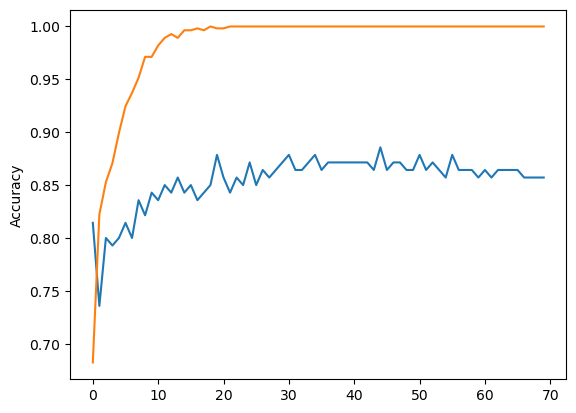

In [14]:
his=model.fit(inp_shuffel,oup_shuffel,batch_size=80, validation_data=(Xval_shuffel,Yval_shuffel), epochs=70, callbacks=model_save)
val_accuracy=his.history['val_accuracy']
training_accuracy=his.history['accuracy']

plt.plot(val_accuracy, label='Test')
plt.plot(training_accuracy, label='Training')
plt.ylabel('Accuracy')

model.save('best_model.hd5')

In [15]:
#Useful to stop overfitting

#callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)]

In [19]:
model=load_model('test-model.hd5')

### Prediction using the model

(299, 299, 3)

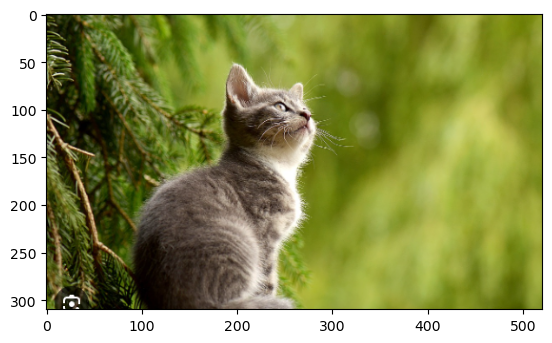

In [22]:
image='/home/sourav/Pictures/Screenshots/image2.png'


image=cv2.imread(image)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)
image=cv2.resize(image,(h,d))


#########################Normalization
mean=[]
max=[]
min=[]
for i in range(3):
    mean.append(np.mean(image[:,:,i]))
    max.append(np.max(image[:,:,i]))
    min.append(np.min(image[:,:,i]))

image.shape

In [23]:

norm_Xpred=np.zeros((h,d,3))

for j in range(h):
    for m in range(d):
        for n in range(3):
            norm_Xpred[j,m,n] =(image[j,m,n]-mean[n])/max[n] -min[n]

################################################################

norm_Xpred=norm_Xpred.reshape(1,h,d,3)


predeiction=model.predict(norm_Xpred)

#predeiction=np.argmax(predeiction)

predeiction



1/1 [==============================] - 0s 44ms/step


array([[6.8894044e-12, 1.0000000e+00]], dtype=float32)

with open('ImageNetLabels.txt', 'r') as file:
    image_label=[]
    image_label=file.read().splitlines()

image_label[predeiction]
